# DINO configuration

Below we initiate the DINO configuration as python class to demonstrate its implementation.

In [2]:
import cmocean as cm
from matplotlib import pyplot as plt
from dino_configuration import DinoConfiguration

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

standard_configuration = DinoConfiguration()

ds = standard_configuration.to_xarray()

## Grid

### Horizontal discretization
DINO is solved on a sphere and discretized by a horizontally isotropic mercator grid. Therefore, the grid-spacing in latitudinal direction decreases towards the poles.

We compute **longitude at T-points** as
$$
\begin{equation*}
    \lambda(i) = \lambda_{0} + \Delta \lambda * i
\end{equation*}
$$

where $i \in \left[ 1, I \right]$
and **latitude at T-points** as
$$
\begin{equation*}
    \phi(j) = \frac{180}{\pi} * \arcsin ( \tanh( \Delta \lambda \frac{\pi}{180} * j) )
\end{equation*}
$$

where $j \in \left[ 1, J \right]$. \
The prognostic variables are staggered on an Arakawa C-grid. $I$ and $J$ are chosen to span a domain of 50° from eastern to western boundary and approximately 70° (not exactly, due to the mercator projection in (2)) from equator to both northern and southern boundary. In the following we show an example of the resulting grid spacing along $y$ (e2t) and $x$ (e1t) in meters for $\Delta \lambda = 1.0$:

Text(0.5, 0, 'longitude [°E]')

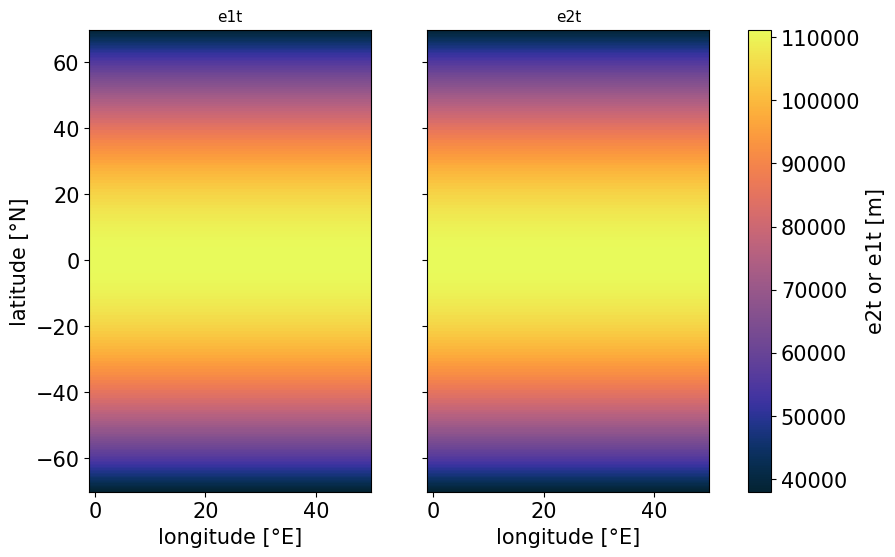

In [14]:
fig, axs = plt.subplots(1,2,figsize=(10,6), sharey=True)
a = ds.e1t.plot(x='lon_c', y='lat_c', cmap=cm.cm.thermal, ax=axs[0], add_colorbar=False)
b = ds.e2t.plot(x='lon_c', y='lat_c', cmap=cm.cm.thermal, ax=axs[1], add_colorbar=False)
cbar1 = fig.colorbar(a, ax=axs[:3], label=r'e2t or e1t [m]')
axs[0].set_title(r'e1t')
axs[1].set_title(r'e2t')
axs[0].set_ylabel('latitude [°N]')
axs[1].set_ylabel('')
axs[0].set_xlabel('longitude [°E]')
axs[1].set_xlabel('longitude [°E]')

### Vertical discretization
Since this [commit](https://github.com/vopikamm/DINO/commit/084122893073255b154f7fba188f7683ea80331a) DINO has the option for a full step z* vertical coordinate. It follows exactly the same stretching function as the hybrid sigma-z coordinate, but assuming a flat bottom: \
With
$$
    \begin{align*}
    a_0 &= \left( dz_{min} - \frac{H - h_{co}}{K - 1 - k_{const}}\right)/
              \left(\tanh{\left(\frac{1 - k_{th}}{a_{cr}}\right)} - a_{cr} \cdot \frac{\ln{\left( \cosh{\left(\frac{K - k_{const} - k_{th}}{a_{cr}}\right)}\right)} - \ln{\left(\cosh{\left(\frac{1 - k_{th}}{a_{cr}}\right)}\right)}}{K - 1 - k_{const}}\right) \\
   a_1 &= dz_{min} - a_0 \cdot \tanh{\left(\frac{1 - k_{th}}{a_{cr}}\right)} \\

   a_2 &= -a_1 - a_0 \cdot a_{cr} \cdot \ln{\left(\cosh{\left(\frac{1 - k_{th}}{a_{cr}}\right)}\right)}

    \end{align*}
$$

We compute the **depth at T-points**
$$
    z_t = a_2 + a_1 \cdot k_t + a_0 \cdot a_{cr} \cdot \ln{\left(\cosh{\left(\frac{k_w - k_{th}}{a_{cr}}\right)}\right)} + h_{co},
    $$
where

$$  k_t = k - k_{const} + 0.5 $$

and **depth at W-points**
$$
   z_w = a_2 + a_1 \cdot k_w + a_0 \cdot a_{cr} \cdot \ln{\left(\cosh{\left(\frac{k_t - k_{th}}{a_{cr}}\right)}\right)} + h_{co},
$$

where

$$  k_w = k - k_{const} $$ 

This is done once for the top z-level using the parameters
$$
    \begin{align*}
        &H = 4000 &&: \text{Depth of the bottom [meters]} \\
        &dz_{min} = 10 &&: \text{Value of e3 at the connection point [meters]} \\
        &h_{co} = 0 &&: \text{Depth of the connection between z- and s-coordinat es [meters]} \\
        &k_{th} = 35 &&: \text{Position of the inflexion point} \\
        &k_{const} = 0 &&: \text{Index of last level with z-coordinates} \\
        &a_{cr} = 10.5 &&: \text{Slope of the tanh function},
    \end{align*}
$$

and then repeated for the bottom "sigma"-level with adapted diagnosed parameters

$$
    \begin{align*}
        &k_{const} &&= argmin(abs(z_w - 1000m) &&: \text{Index of last level with z-coordinates} \\
        &dz_{min} &&= diff(z_t)[k_{const}] &&: \text{Value of e3 at the connection point [meters]} \\
        &h_{co} &&= z_w[k_{const}] &&: \text{Depth of the connection between z- and s-coordinat es [meters]} \\
    \end{align*}
$$

The vertical index $k \in \left[ 1, K \right]$ with $K=36$.
The resulting depth level over k are shown in the following:

Text(0, 0.5, 'depth [m]')

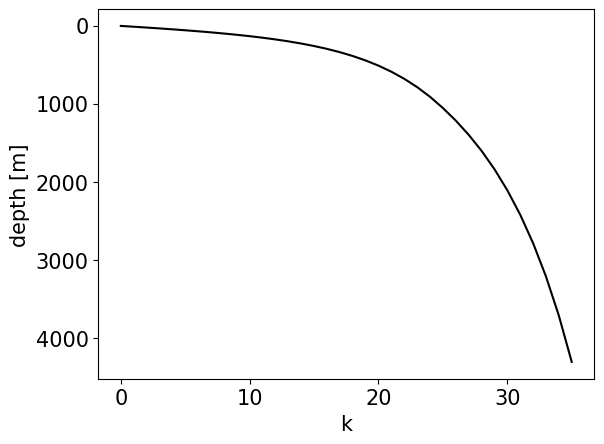

In [15]:
ds.depth_t_1d.plot(yincrease=False, color='black')
plt.xlabel('k')
plt.ylabel('depth [m]')

## Bathymetry
The domain is closed everywhere except a periodic re-entrant channel between $45°S$ and $65°S$. Above $2000m$ depth the domain is bounded by vertical walls, below a tapered exponential defines the slopes. A semi-circular sill with a Gaussian shape introduces a pressure gradient in the channel, similar to the Neverworld2 configuration. The exact implementation is demonstrated in `DinoConfiguration.get_bathymetry()` and `DinoConfiguration.add_gaussian_ring()`. In the following we show the resulting bathymetry for the standard configuration:   

Text(0.5, 0, 'longitude [°E]')

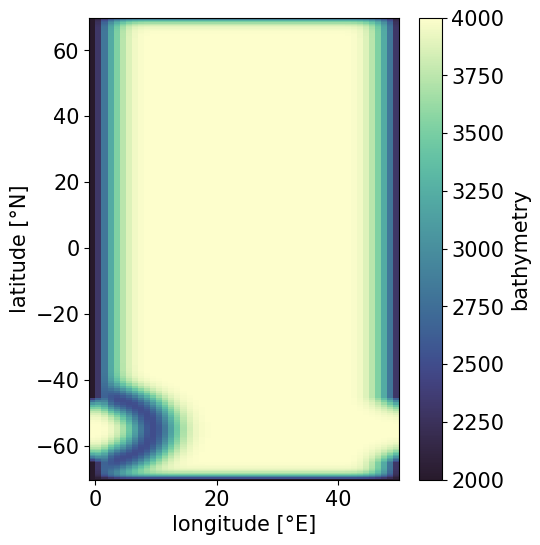

In [16]:
ds.bathymetry.plot(x='lon_c', y='lat_c', figsize=(5,6), cmap=cm.cm.deep_r)
plt.ylabel('latitude [°N]')
plt.xlabel('longitude [°E]')

## Equation of State (EOS)
We follow the simplified EOS from [Roquet et al. (2015)](https://doi.org/10.1175/JPO-D-15-0080.1)

$$
\begin{equation*}
    \rho(T,S,p) = \rho_{0} - \left( 
        a_{0} + 
        \frac{1}{2} C_{b} T_{a} +
        T_{h} p 
        \right) T_{a} + b_{0} S_{a}
\end{equation*}
$$

where 
$$
\begin{align*}
T_{a} &= T - 10°C \\
S_{a} &= S - 35 \, \text{g} \, \text{kg}^{-1}
\end{align*}
$$

using the parameters:

$$
\begin{align*}
    &\rho_{0} = 1028 &&: \text{reference density } [\text{kg} \, \text{m}^{-3}] \\
    &a_{0} = 0.1655 &&: \text{thermal expansion } [\text{kg} \, \text{m}^{-3} \, \text{K}^{-1}] \\
    &b_{0} = 0.7655 &&: \text{haline expansion  } [\text{kg}^{2} \, \text{m}^{-3} \, \text{g}^{-1}] \\
    &C_{b} = 9.9 \times 10^{-3} &&: \text{thermal cabbeling } [\text{kg} \, \text{m}^{-3} \, \text{K}^{-2}] \\
    &T_{h} = 2.4775 \times 10^{-5} &&: \text{thermobaricity } [\text{kg}^{-3} \, \text{dbar}^{-1} \, \text{K}^{-1}]
\end{align*}
$$

## Surface Boundary Conditions

We need to define surface boundary conditions for all prognostic variables, namely $U$, $V$, $T$,  and $S$. Regarding momentum we follow [Marques et al 2020](https://doi.org/10.5194/gmd-15-6567-2022) with a purely zonal wind stress profile constructed with a piecewise cubic interpolation between fixed values of latitude.

 Temperature $T$ and salinity $S$ are restored towards meridional profiles, defined through

$$
    T^{*}(\phi) = T^{*}_{n/s} + \left( T^{*}_{eq} - T^{*}_{n/s} \right) \, \sin(\pi \, \frac{\phi + \phi_n}{\phi_n - \phi_s})
$$

and

$$
    S^{*}(\phi) = S^{*}_{n/s} + \left( S^{*}_{eq} - S^{*}_{n/s} \right) \, \left(1 + \cos(\frac{2 \, \pi \, \phi }{\phi_n - \phi_s})\right) / 2 - 1.25 \, e^{- \phi^{2} / 7.5^{2}}
$$

where the subscript $(...)_{n/s}$ denotes the value at the northern or southern boundary, when $\phi < 0$ or $\phi > 0$.
The restoring values for southern, northern boundary and equator are 

$$
\begin{align*}
    &T^{*}_{s} = -0.5°C, &&T^{*}_{n} = -5.0°C, &&T^{*}_{eq} = 27.0°C \\
    &S^{*}_{s} = 35.1 PSU, &&S^{*}_{n} = 35.0 PSU, &&S^{*}_{eq} = 37.25 PSU \\
\end{align*}.
$$

The salinity restoring stays constant throughout the simulation, while a seasonal cosine of magnitude $3.0°C$ (at $T^{*}_{n}$) and $0.5°C$ (at $T^{*}_{s}$) is applied to the boundary values of the temperature restoring. The maximum/minimum restoring lags one month after the respective minimum/maximum in solar radiation. All meridional profiles of surface boundary conditions are visualized below. 

Shortwave solar radiation is adapted from [Caneill et al. 2022](https://doi.org/10.1175/JPO-D-21-0295.1) and given by

$$
Q_{solar}(\phi) = 230. \, \cos\left( \frac{\pi}{180} \, \left[ \phi - 23.5 \, \cos(\pi \,\frac{d+189}{180})\right]\right)
$$

where d is the day of the year controlling a seasonal cycle in the solar forcing.

In [12]:
test = []
for i in range(0,360):
    test.append(standard_configuration.get_q_solar(i))

In [18]:
import numpy as np
mean = np.array(test).mean(axis=0)
maximum = np.array(test).max(axis=0)
minimum = np.array(test).min(axis=0)

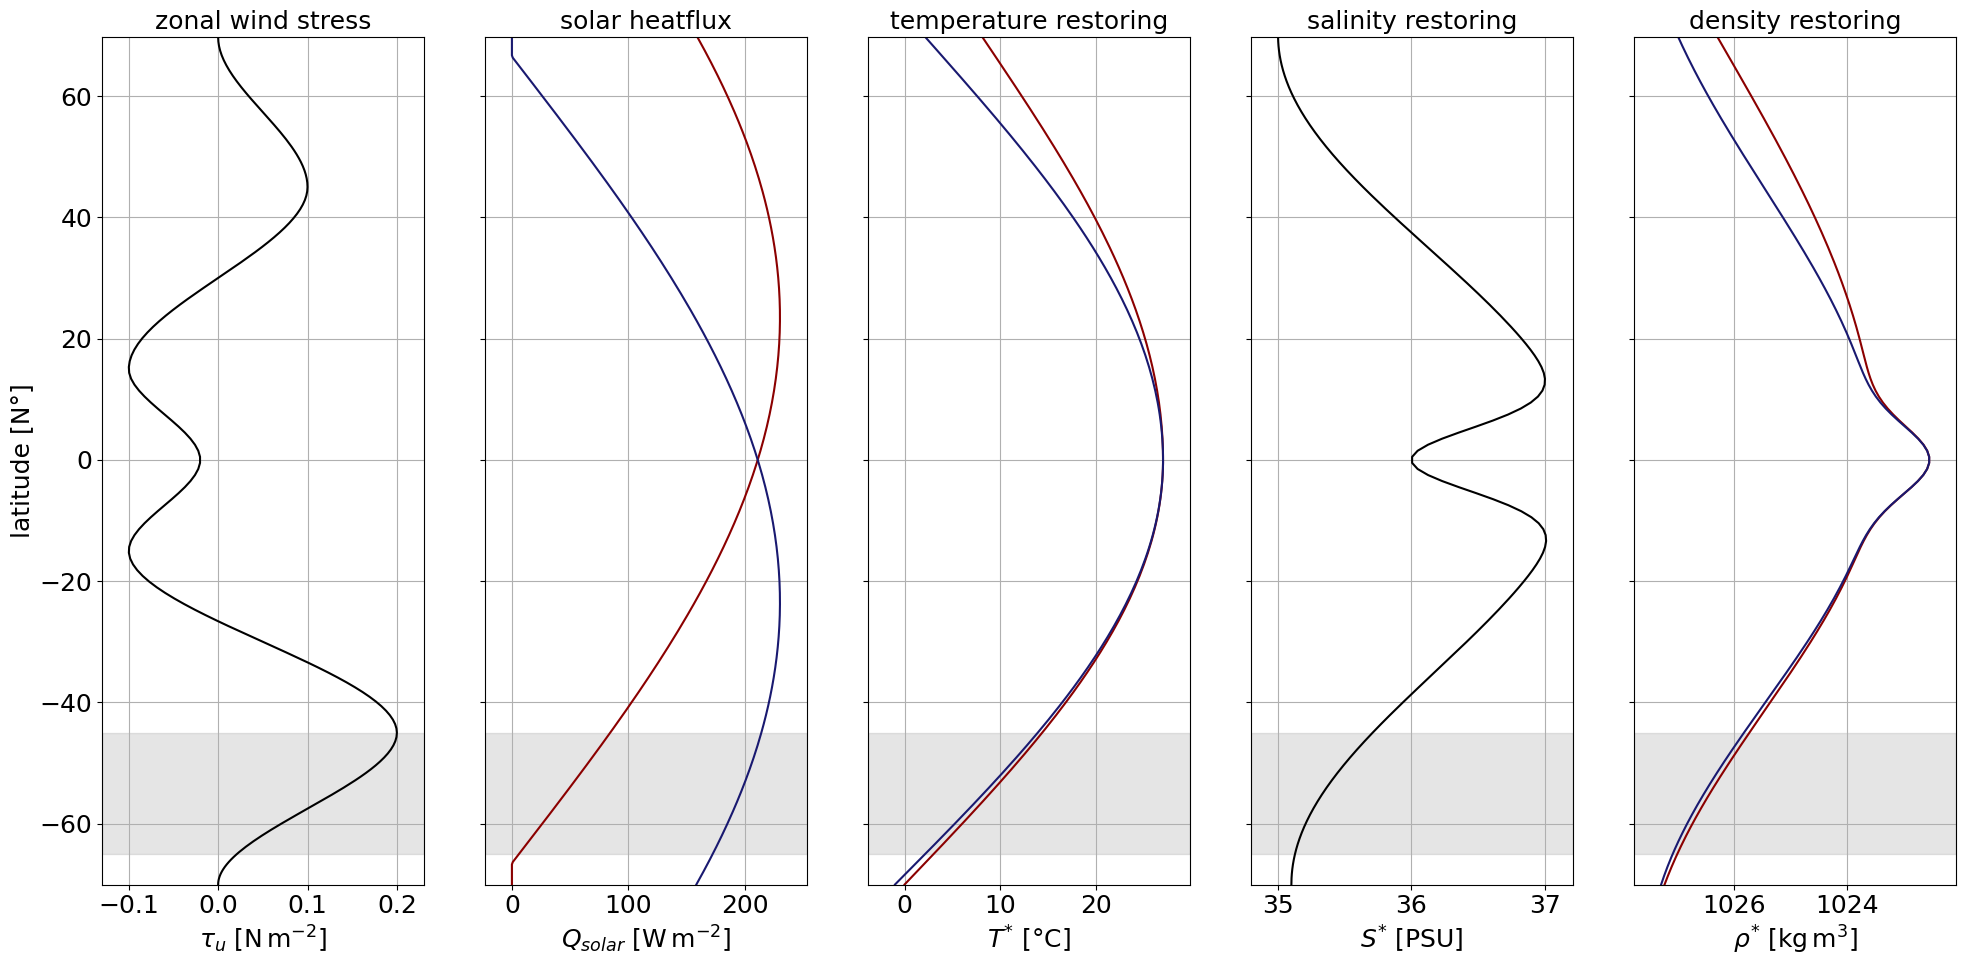

In [9]:
ds['q_solar_july']     = (['y_c'], standard_configuration.get_q_solar(5 * 30 + 21.))
ds['q_solar_january']  = (['y_c'], standard_configuration.get_q_solar(11 * 30 + 21.))

ds['t_star_july']     = (['y_c'], standard_configuration.get_T_star(6 * 30 + 21.))
ds['t_star_january']  = (['y_c'], standard_configuration.get_T_star(12 * 30 + 21.))

ds['rho_star_july']     = (['y_c'], standard_configuration.get_rho_star(6 * 30 + 21.))
ds['rho_star_january']  = (['y_c'], standard_configuration.get_rho_star(12 * 30 + 21.))

fig, axs = plt.subplots(1,5, figsize=(20,10), sharey=True)
ds.utau.plot(color='black', y='lat_c', ax=axs[0])
ds.q_solar_july.plot(color='darkred', y='lat_c', ax=axs[1], label='July')
ds.q_solar_january.plot(color='midnightblue', y='lat_c', ax=axs[1], label='January')
ds.t_star_july.plot(color='darkred', y='lat_c', ax=axs[2], label='21st of July')
ds.t_star_january.plot(color='midnightblue', y='lat_c', ax=axs[2], label='21st of January')
ds.s_star.plot(color='black', y='lat_c', ax=axs[3])
ds.rho_star_july.plot(color='darkred', y='lat_c', ax=axs[4], label='21st of July', xincrease=False)
ds.rho_star_january.plot(color='midnightblue', y='lat_c', ax=axs[4], label='21st of January', xincrease=False)

axs[0].set_ylabel('latitude [N°]')
axs[1].set_ylabel(' ')
axs[2].set_ylabel(' ')
axs[3].set_ylabel(' ')
axs[4].set_ylabel(' ')
axs[0].set_xlabel(r'$\tau_{u}$ [$\text{N} \, \text{m}^{-2}$]')
axs[1].set_xlabel(r'$Q_{solar}$ [$\text{W} \, \text{m}^{-2}$]')
axs[2].set_xlabel(r'$T^{*}$ [°C]')
axs[3].set_xlabel(r'$S^{*}$ [PSU]')
axs[4].set_xlabel(r'$\rho^{*}$ [$\text{kg} \, \text{m}^{3}$]')
axs[0].set_title('zonal wind stress')
axs[1].set_title('solar heatflux')
axs[2].set_title('temperature restoring')
axs[3].set_title('salinity restoring')
axs[4].set_title('density restoring')
axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()
axs[4].grid()
axs[0].margins(x=0.1, y=0)
axs[1].margins(x=0.1, y=0)
axs[2].margins(x=0.1, y=0)
axs[3].margins(x=0.1, y=0)
axs[4].margins(x=0.1, y=0)
axs[0].axhspan(-65, -45, color='grey', alpha=0.2)
axs[1].axhspan(-65, -45, color='grey', alpha=0.2)
axs[2].axhspan(-65, -45, color='grey', alpha=0.2)
axs[3].axhspan(-65, -45, color='grey', alpha=0.2)
axs[4].axhspan(-65, -45, color='grey', alpha=0.2)
#axs[2].legend()
plt.tight_layout()